In [48]:
import os
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as tt
import torch
import torch.nn as nn
import cv2
from tqdm.notebook import tqdm
import torch.nn.functional as F
from torchvision.utils import save_image
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline




In [47]:
data_dir = "D:\Programming\Python\AI\gan\images\cats"



In [46]:
image_size = 64
batch_size = 128
stats = (0.5,0.5,0.5),(0.5,0.5,0.5)

#generic data loader
train_ds = ImageFolder(data_dir, transform=tt.Compose([tt.Resize(image_size),
                                                       tt.CenterCrop(image_size),
                                                       tt.ToTensor(),
                                                       tt.Normalize(*stats)]))
# provides iterable over the dataset
train_dl = DataLoader(train_ds, batch_size, shuffle=True,num_workers=3,pin_memory=True)


In [49]:
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

In [50]:
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

In [ ]:
show_batch(train_dl)

In [52]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)
    


device = get_default_device()

In [54]:
device

train_dl = DeviceDataLoader(train_dl, device)

In [35]:
latent_size = 128

In [57]:
generator = nn.Sequential(

    #in: latent_size x 1 x 1
    nn.ConvTranspose2d(latent_size,512,kernel_size=4,stride=1,padding=0,bias = False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),

    #out 512 x 4 x 4 
    nn.ConvTranspose2d(512,256, kernel_size=4,stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out 256 x 8 x 8 
    nn.ConvTranspose2d(256,128, kernel_size=4, stride=2, padding=1, bias=False), 
    nn.BatchNorm2d(128),
    nn.ReLU(True),

    # out 128 x 16 x 16
    nn.ConvTranspose2d(128,64, kernel_size=4,stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    
    # out 64 x 32 x  32
    nn.ConvTranspose2d(64,3,kernel_size=4,stride=2,padding=1, bias=False),
    nn.Tanh()

    # out 3 x 64 x 64

)

In [67]:
generator = to_device(generator,device)

In [ ]:
xb = torch.randn(batch_size,latent_size,1,1)
fake_images = generator(xb)
show_images(fake_images)

In [55]:
discriminator = nn.Sequential(

    nn.Conv2d(3,64,kernel_size= 4, stride=2 , padding =1  , bias = False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2,inplace=True),

    nn.Conv2d(64,128,kernel_size= 4, stride=2 , padding =1  , bias = False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2,inplace=True),

    nn.Conv2d(128,256,kernel_size= 4, stride=2 , padding =1  , bias = False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2,inplace=True),

    nn.Conv2d(256,512,kernel_size= 4, stride=2 , padding =1  , bias = False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2,inplace=True),

    nn.Conv2d(512, 1, kernel_size=4 , stride=1 , padding=0, bias= False),

    nn.Flatten(),
    nn.Sigmoid()
)

In [60]:
discriminator = to_device(discriminator,device)

In [69]:
# saving image after every epoch

sample_dir = "generated"
os.makedirs(sample_dir, exist_ok= True)

def save_samples(index, latent_tensors,show = True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated_image-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images),os.path.join(sample_dir,fake_fname),nrow = 8)
    print('saving', fake_fname)

    if show:
        fig, ax = plt.subplots(figsize=(8,8))
        ax.set_xticks([]) ; ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(),nrow=8).permute(1,2,0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


saving generated_image-0000.png


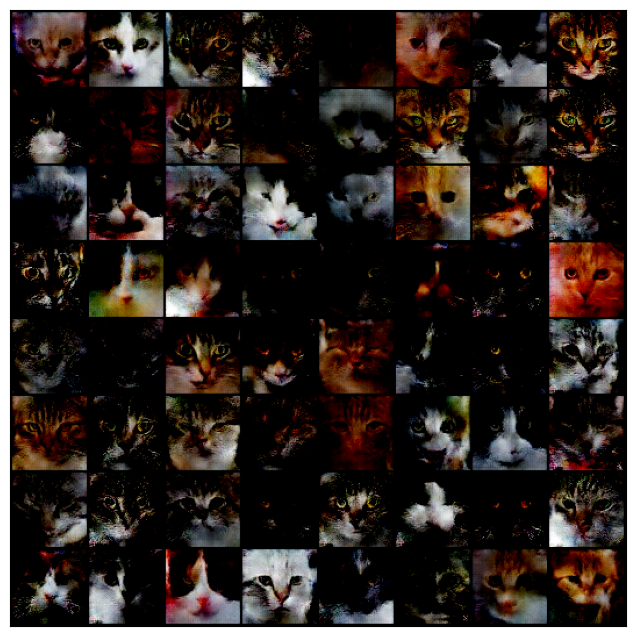

In [82]:
fixed_latent = torch.randn(64,latent_size,1,1,device=device)
save_samples(0, fixed_latent)

In [62]:
def train_discriminator(real_images,opt_d):
    #clears discriminator grad
    opt_d.zero_grad()

    #passing real images thru discriminator
    real_pds = discriminator(real_images)
    real_targets = torch.ones(real_images.size(0),1,device=device)
    real_loss = F.binary_cross_entropy(real_pds, real_targets)
    real_score = torch.mean(real_pds).item()


    #generate fake images
    latent = torch.randn(batch_size,latent_size,1,1,device= device)
    fake_images = generator(latent)

    #pass fake image thru dsicriminator
    fake_targets = torch.zeros(fake_images.size(0),1,device= device)
    fake_pds = discriminator(fake_images)
    fake_loss = F.binary_cross_entropy(fake_pds, fake_targets)
    fake_score = torch.mean(fake_pds).item()


    #update discriminator weights
    loss = real_loss + fake_loss
    loss.backward()
    opt_d.step()

    return loss.item(),real_score,fake_score


In [63]:
def train_generator(opt_g):
    #clearing generator gradients
    opt_g.zero_grad()

    #generateing fake images
    latent = torch.randn(batch_size,latent_size,1,1, device=device)
    fake_images = generator(latent)

    #trying to fool the discriminator
    preds = discriminator(fake_images)
    targets = torch.ones(batch_size, 1 , device = device)
    loss = F.binary_cross_entropy(preds,targets)

    #updating generator weights
    loss.backward()
    opt_g.step()
    return loss.item()


In [71]:
# training function that integrates everything together

def fit(epochs,lr,start_idx=1):
    torch.cuda.empty_cache()

    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []

    opt_d = torch.optim.Adam(discriminator.parameters(),lr=lr,betas= (0.5,0.999))
    opt_g = torch.optim.Adam(generator.parameters(),lr=lr,betas= (0.5,0.999))

    for epoch in range(epochs):
        for real_images, _ in tqdm(train_dl):
            loss_d, real_score,fake_score = train_discriminator(real_images,opt_d)
            loss_g = train_generator(opt_g)

        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)

        print(f'Epoch: {epoch}/{epochs } , loss_g: {loss_g}, loss_d {loss_d}, real score: {real_score}, fake score {fake_score}'
              )
        
        save_samples(epoch+start_idx,fixed_latent,show=False)
        
    return losses_g, losses_d, real_scores, fake_scores
        

In [72]:
history = fit(epochs=60,lr=0.0002)

  0%|          | 0/124 [00:00<?, ?it/s]

Epoch: 0/60 , loss_g: 3.252800941467285, loss_d 0.6368569135665894, real score: 0.7862434387207031, fake score 0.30416709184646606
saving generated_image-0001.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch: 1/60 , loss_g: 3.471646547317505, loss_d 1.251418948173523, real score: 0.40881168842315674, fake score 0.034255512058734894
saving generated_image-0002.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch: 2/60 , loss_g: 2.4137890338897705, loss_d 0.8554964065551758, real score: 0.643210768699646, fake score 0.2423580288887024
saving generated_image-0003.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch: 3/60 , loss_g: 2.842698574066162, loss_d 1.4297797679901123, real score: 0.5481687188148499, fake score 0.26279300451278687
saving generated_image-0004.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch: 4/60 , loss_g: 3.573751449584961, loss_d 0.7097685933113098, real score: 0.6778983473777771, fake score 0.2195843607187271
saving generated_image-0005.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch: 5/60 , loss_g: 1.9890871047973633, loss_d 0.48386621475219727, real score: 0.9090819358825684, fake score 0.26913130283355713
saving generated_image-0006.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch: 6/60 , loss_g: 2.7840099334716797, loss_d 1.4226702451705933, real score: 0.3916563391685486, fake score 0.05781978368759155
saving generated_image-0007.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch: 7/60 , loss_g: 4.246979713439941, loss_d 0.45333966612815857, real score: 0.7230893969535828, fake score 0.041542403399944305
saving generated_image-0008.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch: 8/60 , loss_g: 3.9374024868011475, loss_d 0.4796062707901001, real score: 0.9054361581802368, fake score 0.2961679995059967
saving generated_image-0009.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch: 9/60 , loss_g: 8.84525203704834, loss_d 1.4627270698547363, real score: 0.989374041557312, fake score 0.7063222527503967
saving generated_image-0010.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch: 10/60 , loss_g: 3.9560256004333496, loss_d 0.48994284868240356, real score: 0.7757808566093445, fake score 0.1828625202178955
saving generated_image-0011.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch: 11/60 , loss_g: 4.278380393981934, loss_d 0.33815133571624756, real score: 0.7541889548301697, fake score 0.018032178282737732
saving generated_image-0012.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch: 12/60 , loss_g: 4.309398651123047, loss_d 0.33547478914260864, real score: 0.8877397775650024, fake score 0.18002302944660187
saving generated_image-0013.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch: 13/60 , loss_g: 1.1013346910476685, loss_d 1.181058406829834, real score: 0.48223453760147095, fake score 0.203347846865654
saving generated_image-0014.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch: 14/60 , loss_g: 6.068216323852539, loss_d 0.7110810875892639, real score: 0.8404854536056519, fake score 0.37557220458984375
saving generated_image-0015.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch: 15/60 , loss_g: 4.22743034362793, loss_d 0.2487272024154663, real score: 0.8649467825889587, fake score 0.0786026269197464
saving generated_image-0016.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch: 16/60 , loss_g: 3.9857192039489746, loss_d 0.2451464831829071, real score: 0.8502103686332703, fake score 0.05585756525397301
saving generated_image-0017.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch: 17/60 , loss_g: 5.905219554901123, loss_d 6.201112747192383, real score: 0.003788118716329336, fake score 5.457018414745107e-05
saving generated_image-0018.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch: 18/60 , loss_g: 4.405437469482422, loss_d 0.23600688576698303, real score: 0.8242402076721191, fake score 0.014564655721187592
saving generated_image-0019.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch: 19/60 , loss_g: 7.099133491516113, loss_d 0.6792861819267273, real score: 0.8025660514831543, fake score 0.3291928768157959
saving generated_image-0020.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch: 20/60 , loss_g: 1.7007641792297363, loss_d 4.5497822761535645, real score: 0.020649094134569168, fake score 0.004811362363398075
saving generated_image-0021.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch: 21/60 , loss_g: 7.447311878204346, loss_d 0.41823285818099976, real score: 0.9265434145927429, fake score 0.2651572525501251
saving generated_image-0022.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch: 22/60 , loss_g: 4.003658294677734, loss_d 0.16308268904685974, real score: 0.9786986112594604, fake score 0.12058167159557343
saving generated_image-0023.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch: 23/60 , loss_g: 3.780444860458374, loss_d 0.2229263335466385, real score: 0.9311308860778809, fake score 0.13050074875354767
saving generated_image-0024.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch: 24/60 , loss_g: 0.3210122287273407, loss_d 1.46440851688385, real score: 0.24448202550411224, fake score 0.01076916977763176
saving generated_image-0025.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch: 25/60 , loss_g: 1.9968907833099365, loss_d 0.49961090087890625, real score: 0.6720160841941833, fake score 0.02651992440223694
saving generated_image-0026.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch: 26/60 , loss_g: 5.309064865112305, loss_d 0.3297034502029419, real score: 0.9556291103363037, fake score 0.2271256446838379
saving generated_image-0027.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch: 27/60 , loss_g: 3.8261609077453613, loss_d 0.04549671337008476, real score: 0.9712220430374146, fake score 0.015613380819559097
saving generated_image-0028.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch: 28/60 , loss_g: 2.0683956146240234, loss_d 0.39801889657974243, real score: 0.7834553122520447, fake score 0.06685322523117065
saving generated_image-0029.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch: 29/60 , loss_g: 2.9363393783569336, loss_d 0.323726624250412, real score: 0.7527445554733276, fake score 0.01696481928229332
saving generated_image-0030.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch: 30/60 , loss_g: 0.23030345141887665, loss_d 3.294436454772949, real score: 0.07239475101232529, fake score 0.041327133774757385
saving generated_image-0031.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch: 31/60 , loss_g: 6.602958679199219, loss_d 0.006591104436665773, real score: 0.9962474703788757, fake score 0.0028206557035446167
saving generated_image-0032.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch: 32/60 , loss_g: 6.6914472579956055, loss_d 0.19126173853874207, real score: 0.8362808227539062, fake score 0.002201929222792387
saving generated_image-0033.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch: 33/60 , loss_g: 0.732342541217804, loss_d 2.0229294300079346, real score: 0.14132274687290192, fake score 0.008876403793692589
saving generated_image-0034.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch: 34/60 , loss_g: 5.075720310211182, loss_d 0.11862368881702423, real score: 0.8999152183532715, fake score 0.0039039715193212032
saving generated_image-0035.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch: 35/60 , loss_g: 3.526749610900879, loss_d 0.17327295243740082, real score: 0.8779267072677612, fake score 0.036623384803533554
saving generated_image-0036.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch: 36/60 , loss_g: 4.368347644805908, loss_d 0.4920773208141327, real score: 0.6556931734085083, fake score 0.0018267120467498899
saving generated_image-0037.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch: 37/60 , loss_g: 6.915950775146484, loss_d 1.0057291984558105, real score: 0.88973468542099, fake score 0.5242566466331482
saving generated_image-0038.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch: 38/60 , loss_g: 1.2131516933441162, loss_d 2.8024208545684814, real score: 0.10339993238449097, fake score 9.678466449258849e-05
saving generated_image-0039.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch: 39/60 , loss_g: 3.8331124782562256, loss_d 0.10805688053369522, real score: 0.9383488893508911, fake score 0.04148609936237335
saving generated_image-0040.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch: 40/60 , loss_g: 4.986174583435059, loss_d 0.13069826364517212, real score: 0.9979351758956909, fake score 0.10434845089912415
saving generated_image-0041.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch: 41/60 , loss_g: 0.008280144073069096, loss_d 2.079616069793701, real score: 0.14446812868118286, fake score 0.06395858526229858
saving generated_image-0042.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch: 42/60 , loss_g: 5.359173774719238, loss_d 0.22964662313461304, real score: 0.9860237836837769, fake score 0.16930623352527618
saving generated_image-0043.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch: 43/60 , loss_g: 6.27785587310791, loss_d 0.004309350624680519, real score: 0.9981628656387329, fake score 0.002463830169290304
saving generated_image-0044.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch: 44/60 , loss_g: 5.557428359985352, loss_d 0.08966055512428284, real score: 0.9808038473129272, fake score 0.06360594928264618
saving generated_image-0045.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch: 45/60 , loss_g: 3.3734264373779297, loss_d 0.7158761620521545, real score: 0.5016195774078369, fake score 0.0017348270630463958
saving generated_image-0046.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch: 46/60 , loss_g: 3.4645400047302246, loss_d 0.5007557272911072, real score: 0.694161057472229, fake score 0.003641449846327305
saving generated_image-0047.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch: 47/60 , loss_g: 4.5009870529174805, loss_d 0.23487526178359985, real score: 0.9394113421440125, fake score 0.14852780103683472
saving generated_image-0048.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch: 48/60 , loss_g: 7.621458053588867, loss_d 0.5324470400810242, real score: 0.65666264295578, fake score 0.002237999578937888
saving generated_image-0049.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch: 49/60 , loss_g: 6.884237766265869, loss_d 0.23662559688091278, real score: 0.9798010587692261, fake score 0.18217036128044128
saving generated_image-0050.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch: 50/60 , loss_g: 6.95235013961792, loss_d 0.2950504422187805, real score: 0.7605809569358826, fake score 0.0005834429757669568
saving generated_image-0051.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch: 51/60 , loss_g: 3.818061351776123, loss_d 2.106351613998413, real score: 0.1622779369354248, fake score 0.00013919980847276747
saving generated_image-0052.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch: 52/60 , loss_g: 5.0955352783203125, loss_d 0.11098363995552063, real score: 0.9070125818252563, fake score 0.008378639817237854
saving generated_image-0053.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch: 53/60 , loss_g: 3.155165910720825, loss_d 0.0981728583574295, real score: 0.9287044405937195, fake score 0.02192143350839615
saving generated_image-0054.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch: 54/60 , loss_g: 5.075959205627441, loss_d 0.08414991199970245, real score: 0.9781455993652344, fake score 0.046502213925123215
saving generated_image-0055.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch: 55/60 , loss_g: 4.830916881561279, loss_d 0.11967036128044128, real score: 0.9856917262077332, fake score 0.08640573918819427
saving generated_image-0056.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch: 56/60 , loss_g: 5.495516300201416, loss_d 0.013238941319286823, real score: 0.9988052845001221, fake score 0.011791018769145012
saving generated_image-0057.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch: 57/60 , loss_g: 5.899870872497559, loss_d 0.16971434652805328, real score: 0.9943883419036865, fake score 0.1326380968093872
saving generated_image-0058.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch: 58/60 , loss_g: 0.8390365839004517, loss_d 1.1375740766525269, real score: 0.5084615349769592, fake score 0.002767528872936964
saving generated_image-0059.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch: 59/60 , loss_g: 5.4271392822265625, loss_d 0.07899108529090881, real score: 0.9988877177238464, fake score 0.06790752708911896
saving generated_image-0060.png
